<h1 align="center">The Cyclical Season of Corn Growing and NDVI.</h1>
by. Robert Conti

---

## Introduction
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The amount of land that is dedicated to farming in the United States is unbelievable. Agriculture is really starting to get alot of attention from the tech world due to the numerous application tech can have for our food production. 


### The Data
#### USDA Corn Statistics
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The United States is the largest producer of corn on the planet. Illinois is the second largest corn producer in the US behind Iowa. The USDA has a data base filled with agricultural data where anything produce data can be found.

---
#### NDVI Satellite Images 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; This measurement is specifially used to assess the conduciveness of the surroundings with vegetaion growth.The vegetation metric that will be our focus is the NDVI, or the Normalized Difference Vegetation Index. NDVI image processing is used by farmers and environmentalists to determine the density of green in a given area. To calculate NDVI, the satellite images must be analyzed for wavelengths of both near-infrared and visible light that is being reflected back off of the Earth’s surface. 

The plant pigment found in leaves, chlorophyll, actively absorbs and stores visible (RED) light to be used in the photosynthesis process. Conversely, the cell structure of the leaves intensely reflects near-infrared (NIR) light. Taking a closer look at how these two types of wavelengths are changing over an area of land indicates the density of plants and their leaves, and therefore the health of the surrounding plant life. The equation is NDVI = (NIR - RED) / (NIR + RED).

The use of satellite images and Geographic Information Systems (GIS) in agricultural analysis and forecasting is increasingly being considered a necessity in the industry. Multispectral images taken by UAVs (unmanned aerial vehicles), fix-wing aircrafts, and satellites, including Google Earth images, are processed to provide a variety of different vegetation indices.


* This data comes in the form of .tif files from VegScape which is a mapping tool provided by USDA??. The files are image files but each pixel within the image array is a value between -1 and 1, the NDVI value. 

---

#### Corn data by county for Illinois
##### http://quickstats.nass.usda.gov/results/FA565033-A22A-3A2C-B7EB-9FD7D6B54885

### important Corn Dates
#### Seeding: April-May
#### Flowering: July-Aug 16th
#### Harvest: Oct-Nov

#### Production by county for 1997, 2002, 2007, 20012 
#### http://quickstats.nass.usda.gov/results/8C8F950B-1F92-3847-82BF-6C7CBB7BCA66

#### The full data set
#### http://quickstats.nass.usda.gov/results/35177676-CA0A-3E8A-880B-A00EF6AAC02A

### VegScape
#### https://nassgeodata.gmu.edu/VegScape/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from osgeo import gdal
from PIL import Image

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

sns.set(font_scale=2, style="darkgrid")

### Read in a csv of corn per county in IL and IA
#### The data is groupby by county, year, and one of these additions values:
* Total acres harvested
* Production in bushels
* Total number of opertations
* Number of operations grouped with acres harvested being the constraints

In [2]:
corn_county = pd.read_csv('IL_IA_county_corn_1997_2012.csv')
corn_county.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,CENSUS,2012,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - ACRES HARVESTED",TOTAL,NOT SPECIFIED,"92,361",3.9
1,CENSUS,2012,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - OPERATIONS WITH AREA HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 OR MORE ACRES)",20,8.2
2,CENSUS,2012,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - OPERATIONS WITH AREA HARVESTED",AREA HARVESTED,AREA HARVESTED: (1.0 TO 24.9 ACRES),46,16.5
3,CENSUS,2012,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - OPERATIONS WITH AREA HARVESTED",AREA HARVESTED,AREA HARVESTED: (100 TO 249 ACRES),51,9.2
4,CENSUS,2012,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - OPERATIONS WITH AREA HARVESTED",AREA HARVESTED,AREA HARVESTED: (25.0 TO 99.9 ACRES),61,10.7


## Tidy and clean the data
##### Removing the unnecessary columns: program, period, week ending, geo level, zio code, watershed_code, watershed commodity
* The domain category is important for knowing the number and size of opertations in the county, grouped by a specific range of acres 
* Separate df based on the area harvested ranges, acres harvested, operations, production by county.
* Compare using the number/size of farms to see if they have comparable equipment/means

#### This is getting the corn production and harvest data by county for Illinois ready for plotting and analysis. Chnaging the values which were strings of numbers into ints is important.

In [3]:
df_corn = corn_county[['Year', 'State', 'Ag District', 'County', 'Data Item', 'Domain', 'Domain Category', 'Value']]

# separate by state
df_corn = df_corn.loc[df_corn['Value'] != " (D)"]

illinois = df_corn.loc[df_corn['State'] == 'ILLINOIS']
iowa = df_corn.loc[df_corn['State'] == 'IOWA']

In [4]:
# now taking only the rows with the number of farms in each range for each county
illinois_farms = illinois.loc[illinois['Domain'] == 'AREA HARVESTED']    


illinois_farms['Value'] = illinois_farms['Value'].astype(int)


df_il = illinois_farms.groupby(['Year', 'Ag District', 'Domain Category'], as_index=False)['Value'].sum()

df_il['Acre Range'] = df_il['Domain Category'].str[17:-7]

In [5]:
il_ac = illinois.loc[illinois['Data Item'] == 'CORN, GRAIN - ACRES HARVESTED']
il_prd = illinois.loc[illinois['Data Item'] == 'CORN, GRAIN - PRODUCTION, MEASURED IN BU']

iltmp = il_prd[['Year', 'County', 'Value']]

il_y = pd.merge(il_ac, iltmp, on=['Year', 'County'], how='left')

In [6]:
il_y['Value_x'] = il_y['Value_x'].str.replace(",", "")
il_y = il_y.loc[il_y['Value_x'] != '(D)']

il_y['Value_y'] = il_y['Value_y'].astype(str)
il_y['Value_y'] = il_y['Value_y'].str.replace(",", "")
il_y = il_y.loc[il_y['Value_y'] != 'nan']

il_y['Value_x'] = il_y['Value_x'].astype(int)
il_y['Value_y'] = il_y['Value_y'].astype(int)

### Next we will read in the ndvi .tif images.

#### The source for these files is VegScape, a government run mapping and dataset tool.

* These are .tif files from VegScape. They were manually pulled by state and date and were then extracted from a tar.gz file. Using the library gdal, which is for geospatial and weather computations. Each file is read in as a raster and then turned into a list representing the pixels of the picture. 

* The only issue is that we get the values to be [0, 255] when our NDVI can only have values between [-1, 1]. To fix this we scale the pixel values by multiplying 2/255*data-1. This will rescale the data so it is usable for NDVI values.

* The average NDVI is also calculated for later use and prediction.

In [7]:
# read in all the data to get time series of ndvi
# Hold every week of ndvi data
season_2002 = []
weeks_2002 = []

avg_2002 = []

ndvi_files = 'ndvi_2002'
cnt = 0
for file in os.listdir(ndvi_files):
    if cnt > 0:
        filepath = os.path.join(ndvi_files, file)
        _ndvi = gdal.Open(filepath)
        data = np.array(_ndvi.GetRasterBand(1).ReadAsArray())
        NDVI = 2/255*data-1
        avg_2002.append((NDVI.flatten()).sum()/len(NDVI.flatten()))
        season_2002.append(NDVI)
        weeks_2002.append(file[5:7])
    cnt += 1

In [8]:
season_2007 = []
weeks_2007 = []

avg_2007 = []

ndvi_files = 'ndvi_2007/NDVI_DATA_CACHE'
cnt = 0
for file in os.listdir(ndvi_files):
    if cnt > 0:
        filepath = os.path.join(ndvi_files, file)
        _ndvi = gdal.Open(filepath)
        data = np.array(_ndvi.GetRasterBand(1).ReadAsArray())
        NDVI = 2/255*data-1
        avg_2007.append((NDVI.flatten()).sum()/len(NDVI.flatten()))
        season_2007.append(NDVI)
        weeks_2007.append(file[5:7])
    cnt += 1

In [9]:
season_2012 = []
weeks_2012 = []

avg_2012 = []

ndvi_files = 'ndvi_2012/NDVI_DATA_CACHE'
cnt = 0
for file in os.listdir(ndvi_files):
    if cnt > 0:
        filepath = os.path.join(ndvi_files, file)
        _ndvi = gdal.Open(filepath)
        data = np.array(_ndvi.GetRasterBand(1).ReadAsArray())
        NDVI = 2/255*data-1
        avg_2012.append((NDVI.flatten()).sum()/len(NDVI.flatten()))
        season_2012.append(NDVI)
        weeks_2012.append(file[5:7])
    cnt += 1

## Exploratory Data Analysis

#### The goal here is to visualize and understand what the corn production industry looks like in Illinois while also seeing if there is anything intersting about the NDVI image data.

##### First we will start will a violin plot of the distribution of farm sizes.

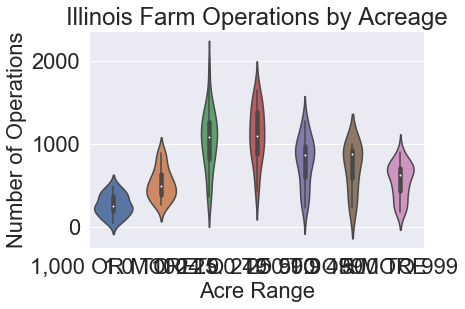

In [10]:
# Get the distribution of the size of farms

sns.violinplot(x='Acre Range', y='Value', data=df_il, font_scale=1)
plt.title('Illinois Farm Operations by Acreage', fontsize=24)
plt.xlabel('Acre Range', fontsize=22)
plt.ylabel('Number of Operations', fontsize=22)
plt.rcParams["figure.figsize"] = [15,10]
plt.show()

#### Normal distribution as is expected for the most part.
* here the violin plot shows the distribution of how many farms operate at a specific acre size, across counties.

* The ranges in the middle are longer and less consolidated on the y-axis

* The variance is wider for the more common acre ranges for farms. 

#### Now plot poduction against area harvested

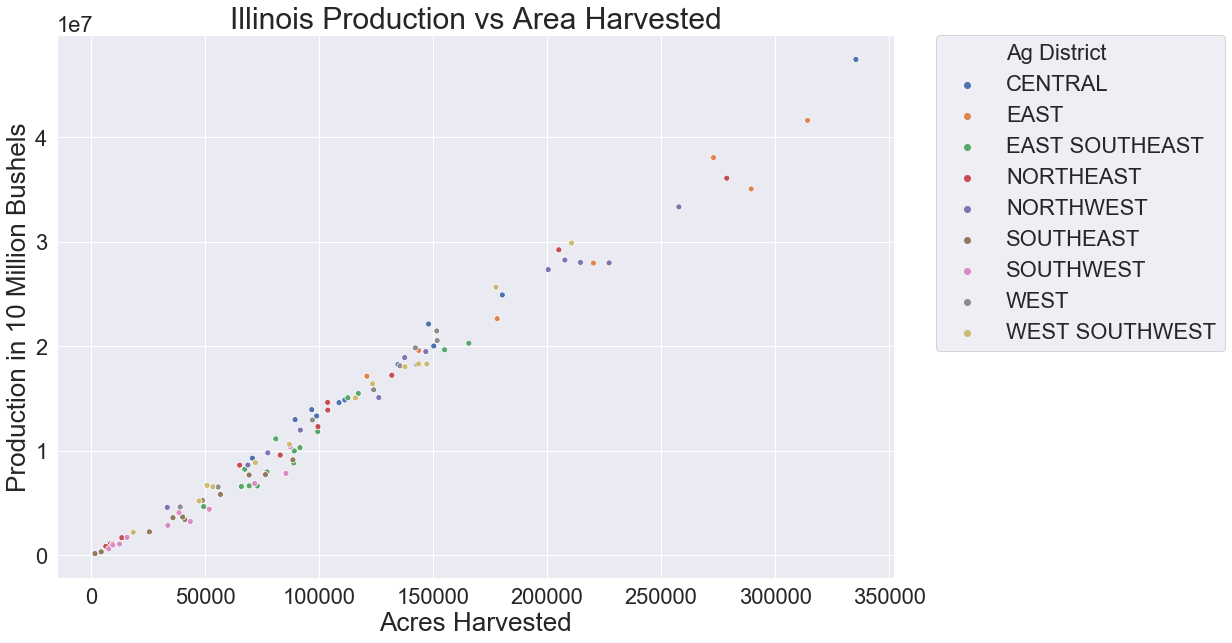

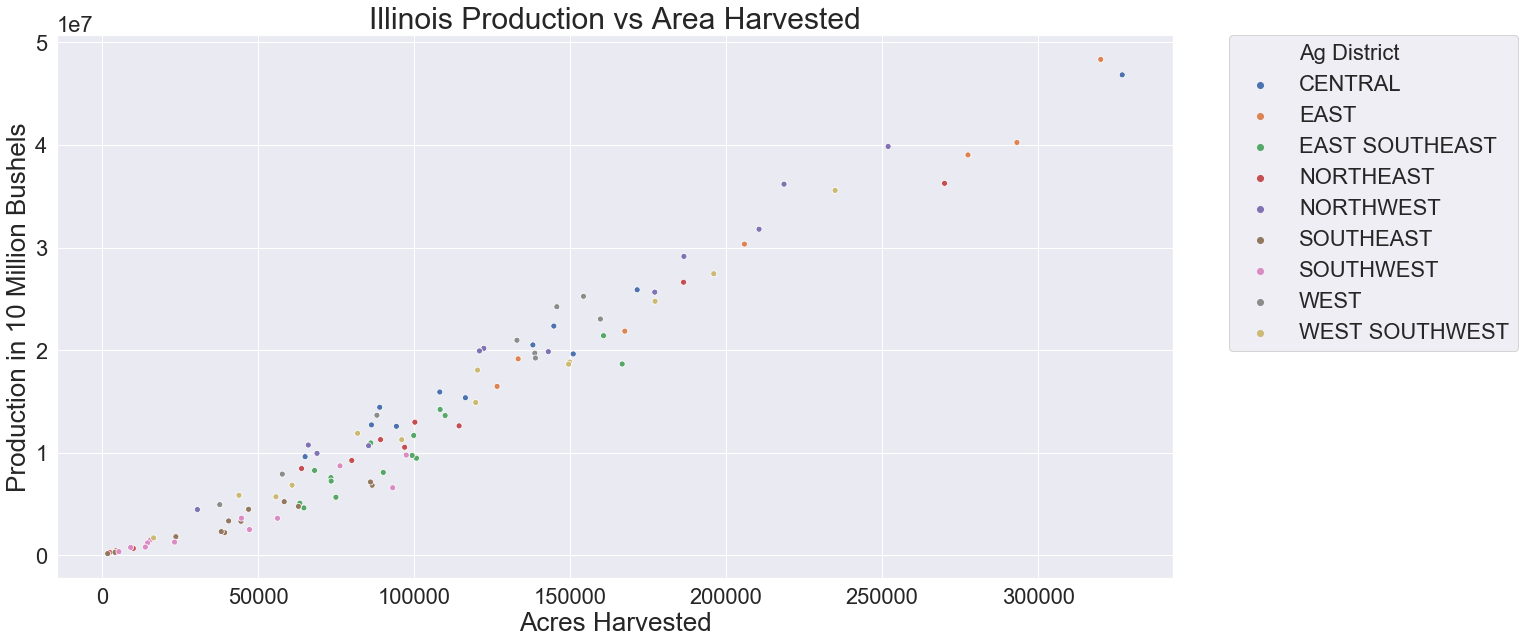

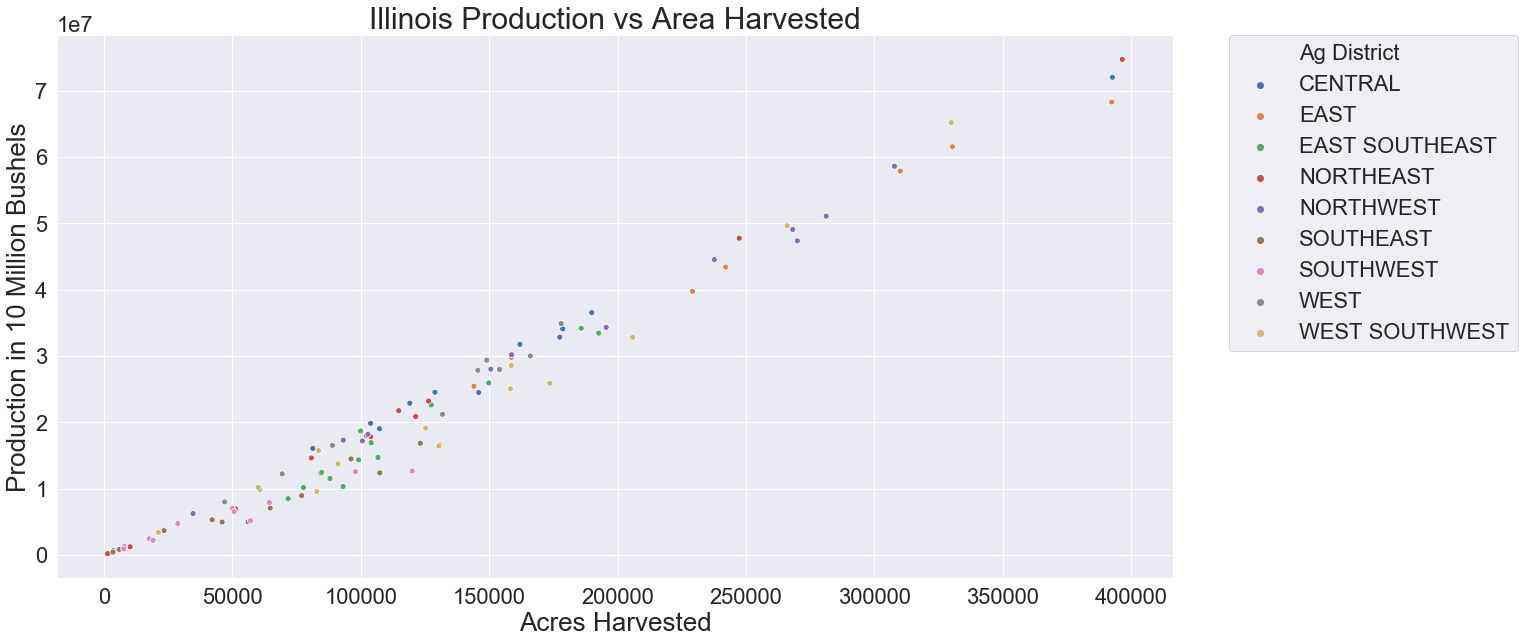

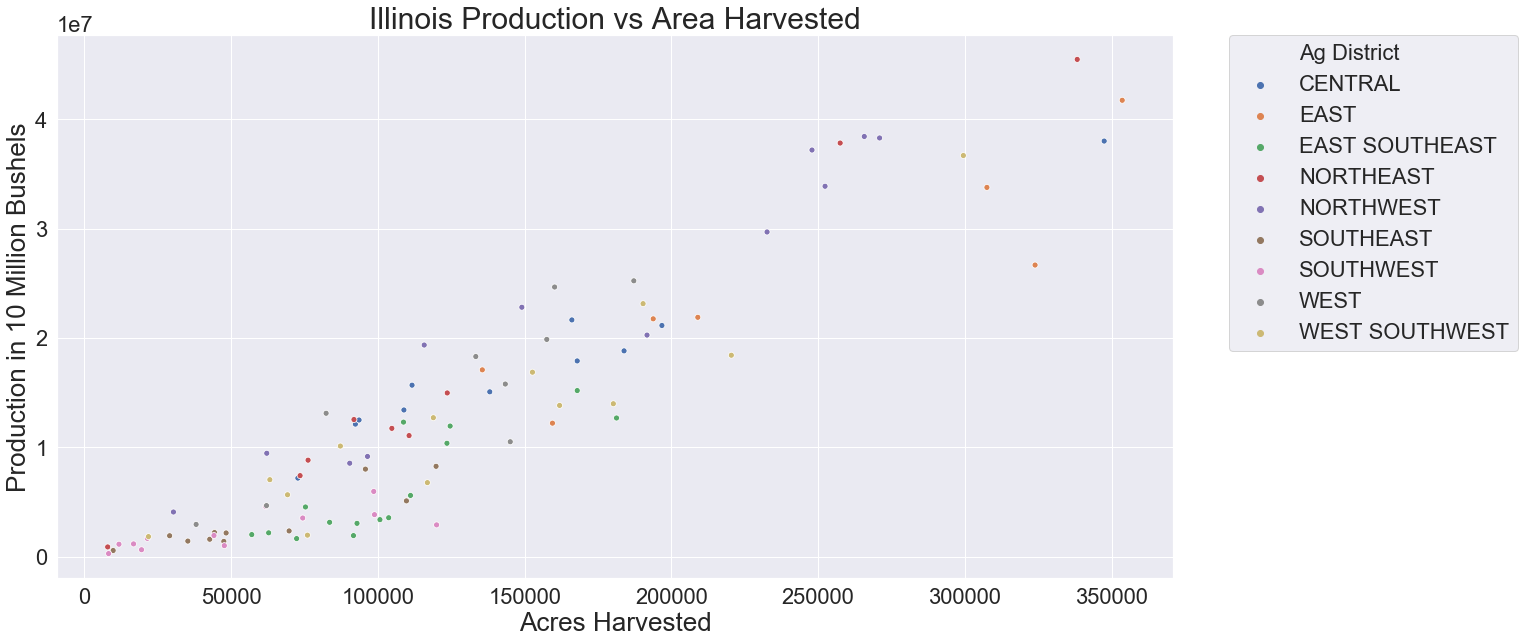

In [11]:
sns.set(font_scale=2)
for year in np.unique(il_y['Year'].values):
    tmp = il_y.loc[il_y['Year'] == year]
    sns.scatterplot(x='Value_x', y='Value_y', data=tmp, hue='Ag District')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Illinois Production vs Area Harvested', fontsize=30)
    plt.xlabel('Acres Harvested', fontsize=26)
    plt.ylabel('Production in 10 Million Bushels', fontsize=26)
    plt.rcParams["figure.figsize"] = [20,10]
    plt.show() 

* This is counties plotted based on the Agricultural region they preside. The plot shows a very clear trend and is concentrated in the bottom lefthand corner.

* The relationship between bushels of corn and acres, also know as yield = bushels/acres, is definetly linear.

* It makes sense that the mmore land you harvest the bigger your harvest will be. 

* Hower, it is the case that very few counties are producing a significant amount of corn. These are industrial scale farms but small farms are numerous and account for the congestion near the bottom left corner. 

---
* The fact that there are so many smaller farms and counties makes it so there is no weak link in the system of corn production. The farms and counties are distibuted across the state evenly, distributing the production to multiple areas.

### The NDVI images give us something like this.

##### These image files start at the 10th week of the year and ends around the 43rd week. This is the corn growing season especailly in the midwest.

* NDVI mesasures how green the vegetation is at a certain location. 

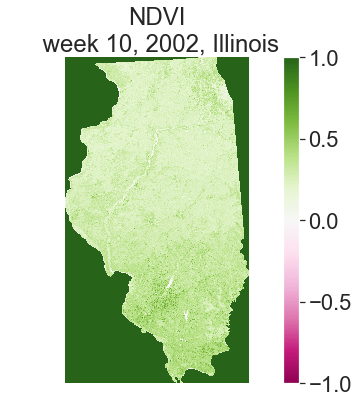

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
ndvi = ax.imshow(season_2002[0], cmap='PiYG',
                vmin=-1, vmax=1)
fig.colorbar(ndvi, fraction=.05)
ax.set(title='NDVI\n week '+weeks_2002[0]+', 2002, Illinois')
ax.set_axis_off()
plt.show()

##### Here is can be see that in the beginning of the season the NDVI is somewhat low or at least very white throughout the state.

##### It can be seen that the Southern part of the state looks the greenest as it should.

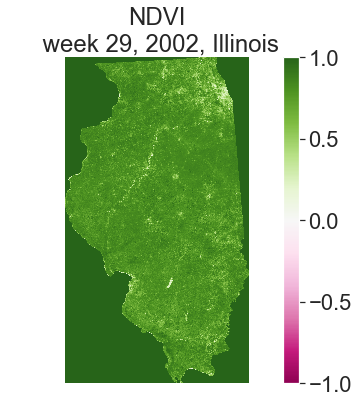

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
ndvi = ax.imshow(season_2002[16], cmap='PiYG',
                vmin=-1, vmax=1)
fig.colorbar(ndvi, fraction=.05)
ax.set(title='NDVI\n week '+weeks_2002[16]+', 2002, Illinois')
ax.set_axis_off()
plt.show()

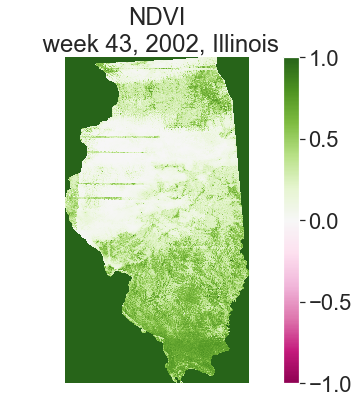

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
ndvi = ax.imshow(season_2002[32], cmap='PiYG',
                vmin=-1, vmax=1)
fig.colorbar(ndvi, fraction=.05)
ax.set(title='NDVI\n week '+weeks_2002[32]+', 2002, Illinois')
ax.set_axis_off()
plt.show()

##### Here are three graphs each visualizing the averge NDVI for each location designated by a pixel. The conditions for crops are expected to get better as the season moves further in summer. And then lower as the season moves into fall and winter

##### The amount of green indicating the NVDI intensity in the week 29 image and the week 10 image is signifcant. These two dates are important because they mark around the time when planting occurs and when the plants will be growing the most.

##### The week 43 graph is very interesting because there are big streaks of white across the NDVI image which suggests there is a lower amount of vegetation there. The only thing is that there is still significant vegetation elsewhere in the state. 
* This most likely has to do with farmers harvesting their crops and reducing the amount of vegetation covering the ground.

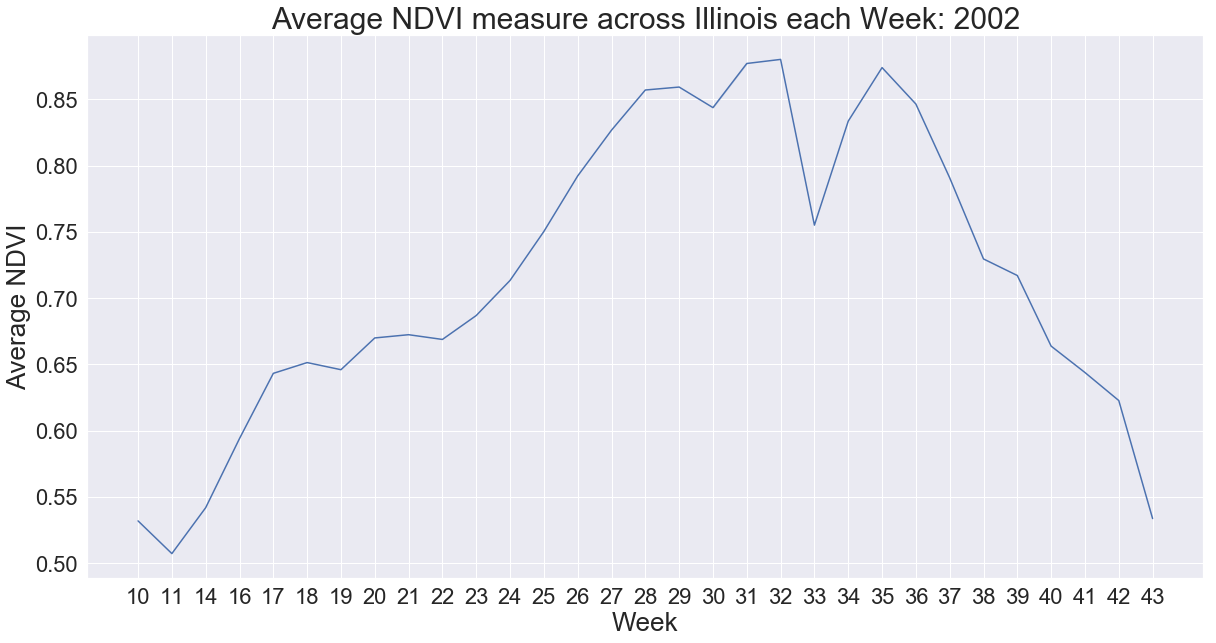

In [15]:
# Plot the average of ndvi per week for the season
ndvi_plot = pd.DataFrame()
ndvi_plot['Avg NDVI'] = avg_2002
ndvi_plot['week'] = weeks_2002
#print(ndvi_plot)
sns.lineplot(x='week', y='Avg NDVI', data=ndvi_plot)
plt.title('Average NDVI measure across Illinois each Week: 2002', fontsize=30)
plt.xlabel('Week', fontsize=26)
plt.ylabel('Average NDVI', fontsize=26)
plt.rcParams["figure.figsize"] = [20,10]
plt.show() 

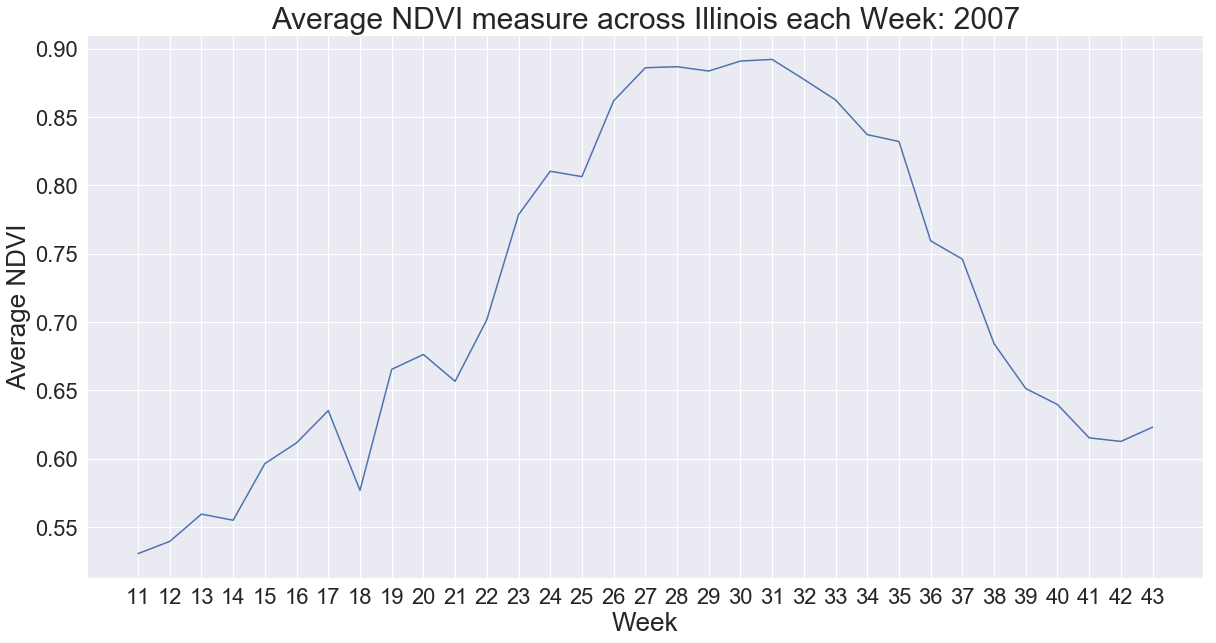

In [16]:
# Plot the average of ndvi per week for the season
ndvi_plot = pd.DataFrame()
ndvi_plot['Avg NDVI'] = avg_2007
ndvi_plot['week'] = weeks_2007
#print(ndvi_plot)
sns.lineplot(x='week', y='Avg NDVI', data=ndvi_plot)
plt.title('Average NDVI measure across Illinois each Week: 2007', fontsize=30)
plt.xlabel('Week', fontsize=26)
plt.ylabel('Average NDVI', fontsize=26)
plt.rcParams["figure.figsize"] = [20,10]
plt.show() 

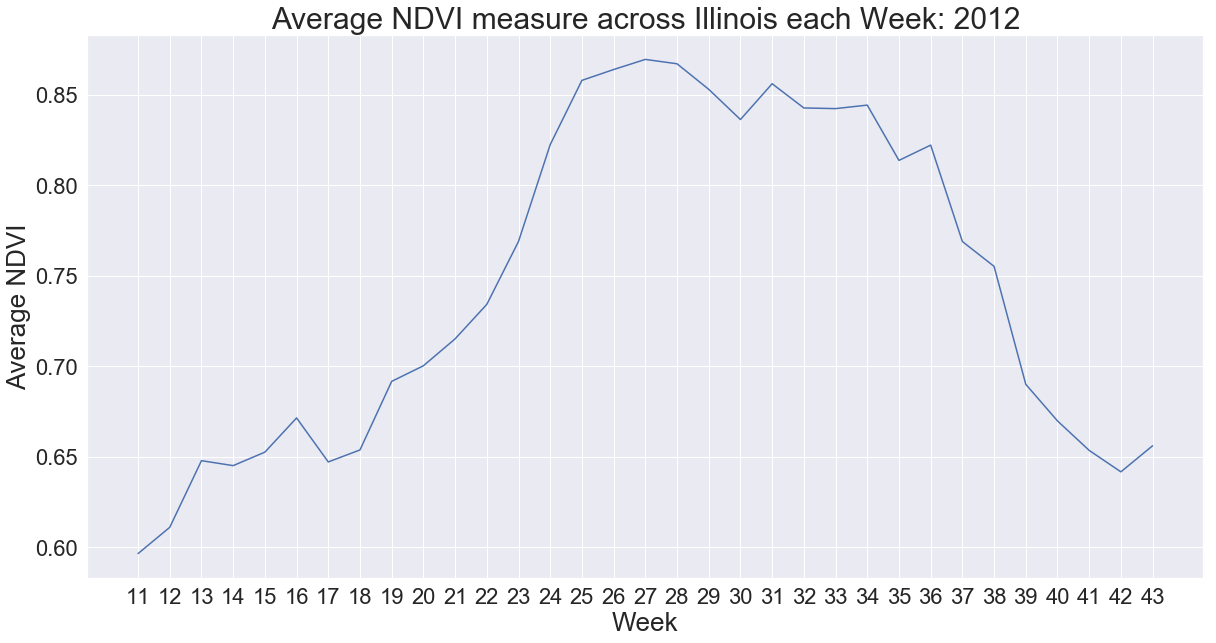

In [17]:
# Plot the average of ndvi per week for the season
ndvi_plot = pd.DataFrame()
ndvi_plot['Avg NDVI'] = avg_2012
ndvi_plot['week'] = weeks_2012
#print(ndvi_plot)
sns.lineplot(x='week', y='Avg NDVI', data=ndvi_plot)
plt.title('Average NDVI measure across Illinois each Week: 2012', fontsize=30)
plt.xlabel('Week', fontsize=26)
plt.ylabel('Average NDVI', fontsize=26)
plt.rcParams["figure.figsize"] = [20,10]
plt.show() 

* The graphs for each year plotted show a parabolic relationship with time during the growing season. NDVI decreases as the season transitions into Fall.

* Corn is usaully done growing at around week 30 during the growing season and these charts show decline in the NDVI happens when the corn is finished with it for the most part.

## Create the data frame to be used in the model

##### When relating the the average NDVI with the week it is going to be a non linear relationship. this is purely due to the fact that the seasons are cyclical which cause changes in the vegetation.

##### A support vector machine will be used as a non linear regression model. Also to see the results a linear regression is done on the smae data.  

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [19]:
X = pd.DataFrame()

X['week'] = weeks_2002
y = pd.DataFrame()
y['avg_ndvi'] = avg_2002

print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

(33, 1)
(33, 1)


Coefficients: 
 [[0.0062492]]
Coefficients: 
 [[0.00638547]]
Residual sum of squares: 0.02
Variance score: -0.11
Variance score: -0.19


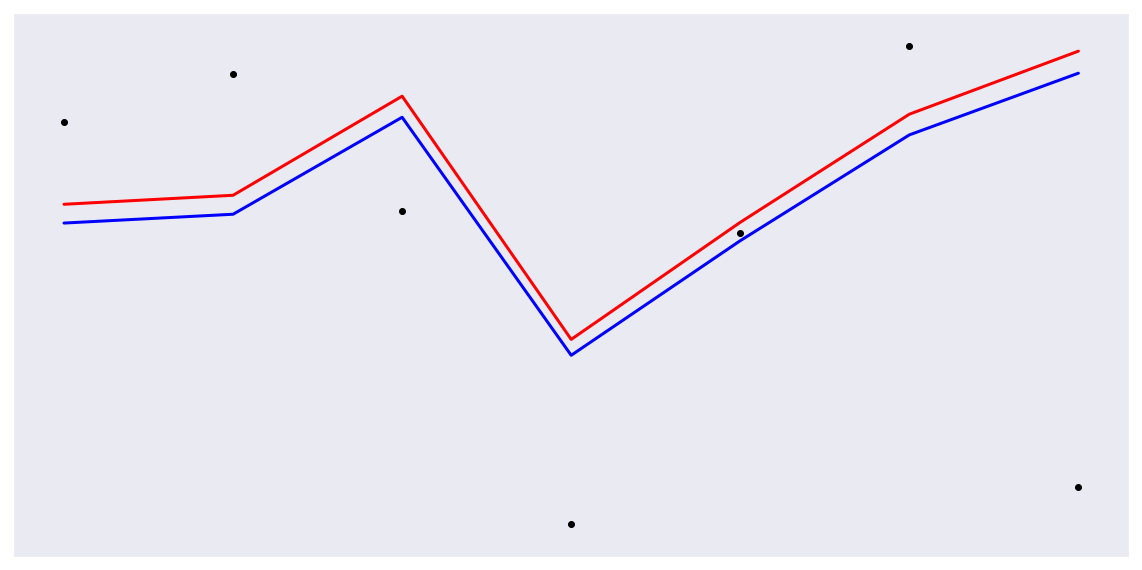

In [20]:
svr = SVR(kernel='linear')
clf = LinearRegression()

svr.fit(X_train, y_train)
clf.fit(X_train, y_train)

svr_pred = svr.predict(X_test)
predictions = clf.predict(X_test)


print('Coefficients: \n', clf.coef_)
print('Coefficients: \n', svr.coef_)

# The mean square error
print("Residual sum of squares: %.2f" % np.mean((predictions - y_test) ** 2))


# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % clf.score(X_test, y_test))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % svr.score(X_test, y_test))


# Plot outputs
plt.scatter(X_test['week'], y_test['avg_ndvi'],  color='black')
plt.plot(X_test['week'], clf.predict(X_test), color='blue', linewidth=3)
plt.plot(X_test['week'], svr.predict(X_test), color='red', linewidth=3)


plt.xticks(())
plt.yticks(())

plt.show()

The models are clearly having trouble with predicting what the average NDVI will for each the week. There will need to be more variables to further the model.
To create a better model some data to look for might be localized weather data to compare againt the NDVI and time of year. Additional image processing can also be done on the NDVI images and other spectral images. 

Trying to predict when the majority of farmers harvest their crop would be an interesting classification model with the images on later weeks in the growing seaon. Checking these images for when large patches start to go missing could lead to predictive power for when crops are projeted to be harvestable.

#### I actually grew up on a farm so being able to merge my roots and my craft is always exciting. Knowing how hard a job farming is and finding out I could help in some capacity is motivating. 

#### We all need food to eat and it doesn't grow itself. With our ability to understand technology and data the problems that the agricultural industry face can be meet with innovative solutions that belong in the 21st century. 

